In [81]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import MaxPooling1D, Conv1D
from keras.layers import GRU, LSTM, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Reshape 
from keras.layers import Lambda 

from keras import regularizers

from sklearn.metrics import confusion_matrix
import itertools

from UtilNNDL import create_window_data
from UtilNNDL import plot_hist
from UtilNNDL import prepare_data
from UtilNNDL import plot_confusion_matrix
from UtilNNDL import bandpass_cnt
from UtilNNDL import exponential_running_standardize


In [2]:
#Prepare the data by taking out nans and dividing into test and train
file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
train_data, test_data, train_labels, test_labels = prepare_data(file_path, 
                                                                num_test_samples = 50, 
                                                                verbose= False, 
                                                                return_all=True,
                                                                num_files =1)
print train_data.shape
print train_labels.shape
print test_data.shape
print test_labels.shape

(237, 22, 1000)
(237, 4)
(50, 22, 1000)
(50, 4)


In [3]:
#assist numerical stability
train_data = train_data*(1e6)
test_data = test_data*(1e6)

In [4]:
#Bandpass filter the data
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2)
print train_data.shape
print test_data.shape
for i,a in enumerate(train_data):
    train_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)
for i,a in enumerate(test_data):
    test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
print train_data.shape
print test_data.shape

(237, 1000, 22)
(50, 1000, 22)
(237, 1000, 22)
(50, 1000, 22)


In [5]:
#Standardize the data
for i,a in enumerate(train_data):
    train_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
for i,a in enumerate(test_data):
    test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2) 
print train_data.shape
print test_data.shape

(237, 22, 1000)
(50, 22, 1000)


In [65]:
#Augment the data into a bigger set by windowing
windows = 150
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=windows)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=windows)
print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape 

(35550, 22, 512)
(35550, 4)
(7500, 22, 512)
(7500, 4)


In [66]:
#Add an additional axis for Conv2D
traindata2d = train_data_sliced.reshape(train_data_sliced.shape[0], train_data_sliced.shape[2], train_data_sliced.shape[1], 1)
testdata2d = test_data_sliced.reshape(test_data_sliced.shape[0], test_data_sliced.shape[2], test_data_sliced.shape[1], 1)
print traindata2d.shape
print testdata2d.shape

(35550, 512, 22, 1)
(7500, 512, 22, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_130 (Conv2D)          (None, 488, 22, 40)       1040      
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 488, 1, 40)        35240     
_________________________________________________________________
batch_normalization_63 (Batc (None, 488, 1, 40)        160       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 29, 1, 40)         0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 29, 1, 40)         0         
_________________________________________________________________
flatten_61 (Flatten)         (None, 1160)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 4)                 4644      
Total para

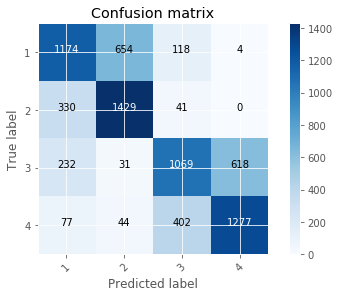

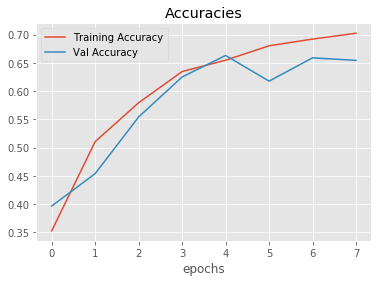

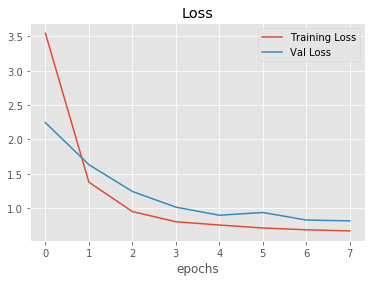

In [85]:
# Conv2D + LSTM
#windows = 150
model = Sequential()
model.add(Conv2D(40, kernel_size=(25,1), activation='relu', data_format='channels_last', input_shape=(512, 22, 1), 
                 kernel_initializer='glorot_normal')) 
model.add(Conv2D(40, kernel_size=(1,22), activation='relu', kernel_initializer='glorot_normal') ) 
model.add(BatchNormalization(axis=-1))
#model.add(Lambda(lambda x: x ** 2))
model.add(MaxPooling2D(pool_size=(60,1), strides = (15,1)))

model.add(Dropout(0.8))
model.add(Flatten())

model.add(Dense(4, activation='softmax',kernel_initializer='glorot_normal'))#, kernel_regularizer=regularizers.l2(0.05)))
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(traindata2d,train_labels_sliced,epochs=8,validation_split=0.25,batch_size=500)
test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=32)
print "Test Score: {}".format(test_score)
test_predict = model.predict(testdata2d, batch_size=32)
cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
unique, count = np.unique(np.argmax(test_labels_sliced,axis=1),return_counts=True)
print count 
plt.figure(0)
plot_confusion_matrix(cm, classes=["1","2","3","4"])
print np.argmax(test_predict,axis=1).shape
plt.figure(1)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plt.figure(2)
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')

In [36]:
print "test"

test


In [ ]:
#Deeper CNN + LSTM (Golmohammadi paper)
model = Sequential()
model.add(Conv2D(16, kernel_size=(22,1), activation='relu', data_format='channels_last', input_shape=(512, 22, 1)))